<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/working_with_text_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Contents**
- Prepare text for LLM training
- Splitting text into word and subword tokens
- Byte pair encoding
- Sampling training examples
- Convert tokens into vectors that go into LLM

- GPT2 models have model size at 117M and 125M parameters, embedding size of 768.
- GPT3 has 175B parameters and embedding size of 12,288.

## Tokenize text

In [11]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.2 MB/s eta 0:00:00


In [1]:
import urllib.request
import re
from collections import defaultdict

In [2]:
from os import read

def download_data(url, file_path):
  urllib.request.urlretrieve(url, file_path)

def read_data(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    data = f.read()
  return data




url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"
file_path = "verdict.txt"
download_data(url, file_path)
data = read_data(file_path)
print(data[:1000])




I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?

Well!--even through th

- White spaces are useful if we training models to generate code, but if we are operating pure text data, removing it is helpful for lowering memory and cpu constraints

In [3]:
def tokenize_text(text):
  tokens = re.split(r'([,.:;?_!"()\']|--|\s)', text)
  tokens = [token for token in tokens if token.strip()]
  return tokens

tokens = tokenize_text(data)
print(tokens[:30])
print(len(tokens))


['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']
4690


## Convert tokens into integers

In [4]:
class TokenizerV1:
  def __init__(self, text):
    self.text = text
    self.tokens = self.tokenize_text(self.text)
    print(f"Text tokenized {len(self.tokens)}")
    self.word_to_idx = defaultdict(lambda: len(self.word_to_idx))
    self.idx_to_word = defaultdict(lambda : "<UNK>")
    self.build_vocab()
    print(f"Vocab size: {self.vocab_size} constructed")


  def tokenize_text(self, text):
    tokens = re.split(r'([,.:;?_!"()\']|--|\s)', text)
    return [token for token in tokens if token.strip()]


  def build_vocab(self):
    self.tokens.append("<ENDOFTEXT>")
    self.all_words = sorted(set(self.tokens))
    self.vocab_size = len(self.all_words)
    for idx, word in enumerate(self.all_words):
      self.word_to_idx[word] = idx
      self.idx_to_word[idx] = word

  def encode(self, text_to_be_encoded):
    tokens = self.tokenize_text(text_to_be_encoded)
    return [self.word_to_idx[token] for token in tokens]

  def decode(self, encoded_text):
    decoded_text = " ".join([self.idx_to_word[idx] for idx in encoded_text])
    decoded_text = re.sub(r'\s+([,.:;?_!"()\']])', r'\1', decoded_text)
    return decoded_text


tokenizer = TokenizerV1(data)


Text tokenized 4690
Vocab size: 1131 constructed


In [5]:
tokenizer.encode("Jack is a genius")

[58, 585, 116, 487]

In [6]:
tokenizer.decode(tokenizer.encode("Jack is a genius")) == "Jack is a genius"

True

In [10]:
tokenizer.decode(tokenizer.encode("Jack is a genius unknown word <ENDOFTEXT> unrelated sentence begins here"))

'Jack is a genius <UNK> word <ENDOFTEXT> <UNK> <UNK> <UNK> here'

### Bytepair encoding
- OpenAI [tiktoken library](https://github.com/openai/tiktoken) is pretty good
- End of text token is allocated large vocab id of 50256.
- Original model used in ChatGPT had total vocab size of 50, 257 with <|endoftext|> being allocated the largest id.
- How does BPE token handle any unknown word ?
  - It breaks words into smaller words
- How doe BPE work ?
  - Iteratively merges frequent characters into subwords and frequent subwords into words. First all individual characters are added into vocabulary, then all frequent double pairs are added into vocab. An example of a common double pair is "de", it occurs in depend, hidden, depend, made, define. Merges are determined by frequency cutoffs.

  



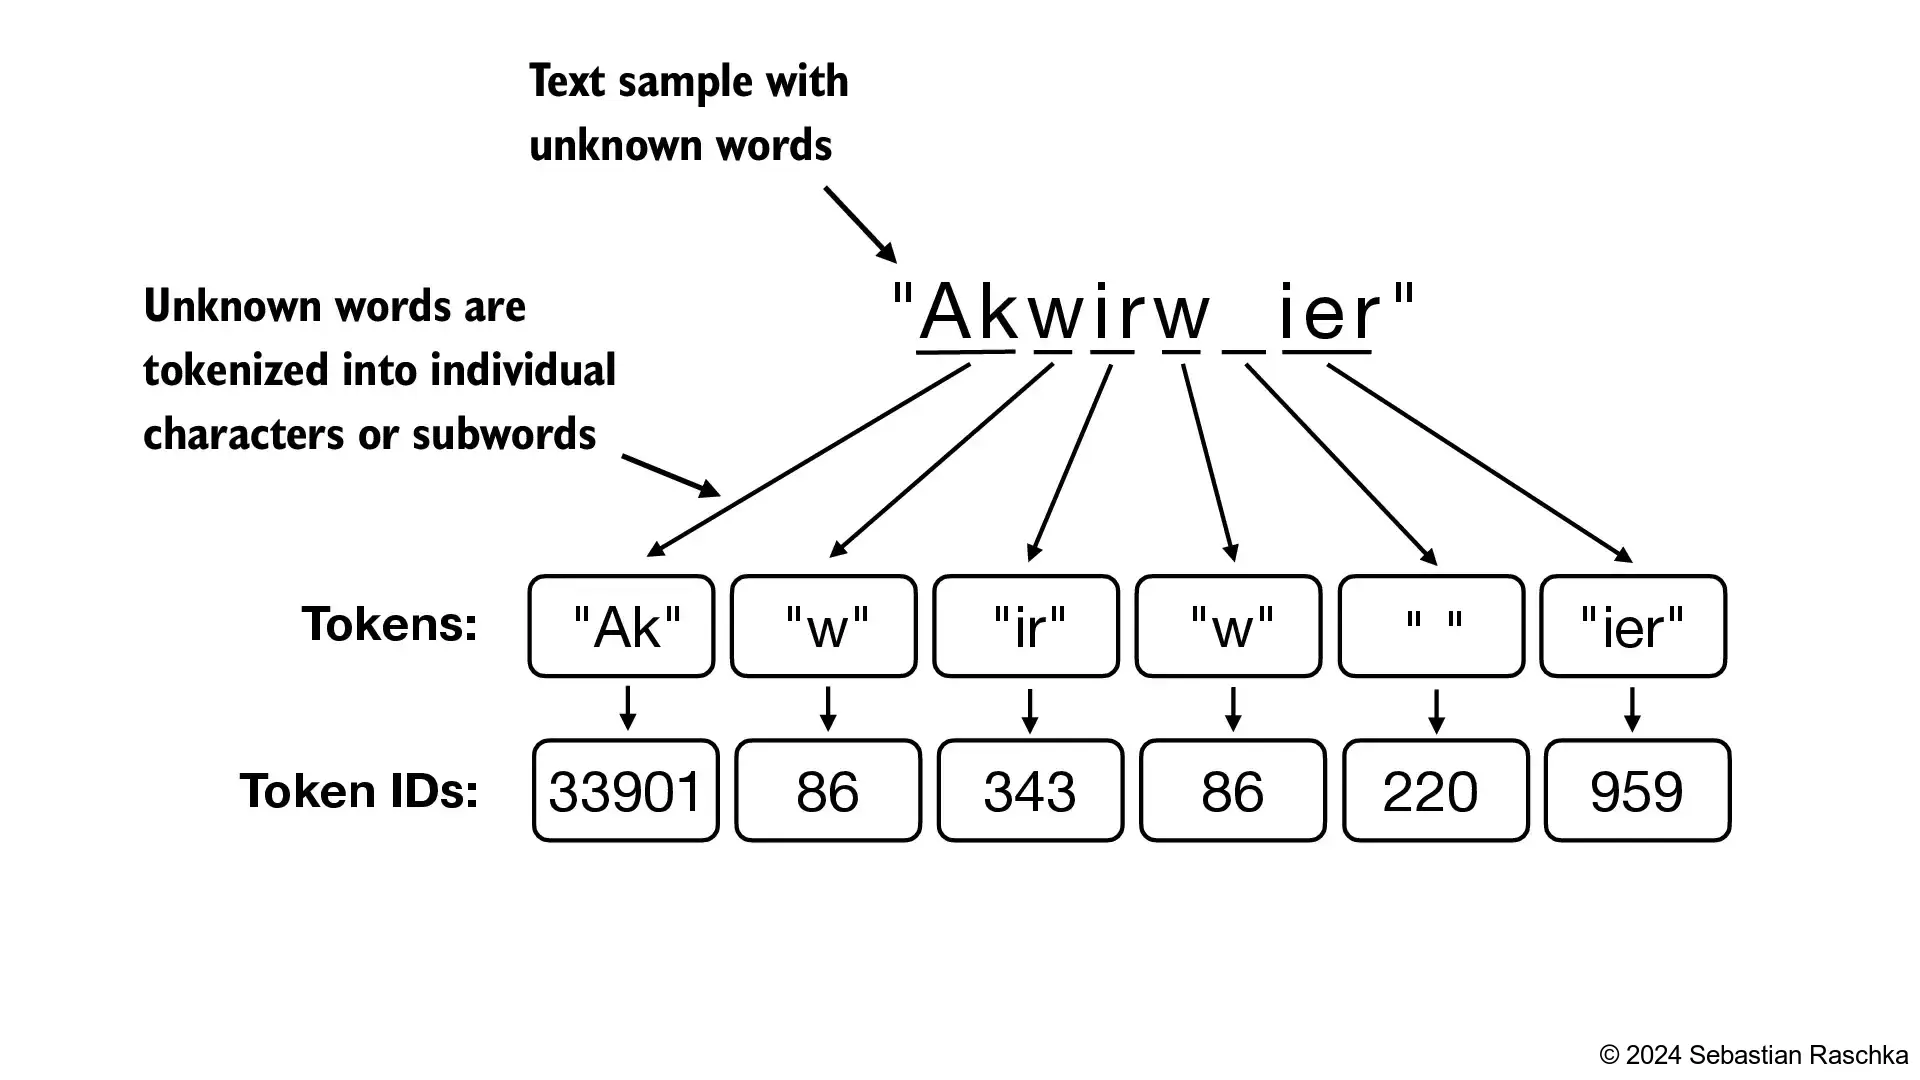

In [5]:
import tiktoken

bpe_tokenizer = tiktoken.get_encoding("gpt2")

text = "Jack is a genius unknown word <|endoftext|> unrelated sentence begins here"
tokens = bpe_tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(tokens)
print(bpe_tokenizer.decode(tokens))

[14295, 318, 257, 15632, 6439, 1573, 220, 50256, 19938, 6827, 6140, 994]
Jack is a genius unknown word <|endoftext|> unrelated sentence begins here


In [18]:
bpe_tokenizer.encode("Ajay Prasadh Viswanathan"), bpe_tokenizer.decode(bpe_tokenizer.encode("Ajay Prasadh Viswanathan"))

([32, 33708, 1736, 292, 24411, 6911, 8149, 6696], 'Ajay Prasadh Viswanathan')

### Data sampling with a sliding window
- Goal is to predict target word based on an input text
- If we have an intermediate dataset with paris of inputs and outputs where outputs are inputs right shifted by 1, then it easy to prepare the context prediction dataset.
  - Next word in sequence becomes prediction target
  - Output tokens are input tokens shifted by 1.

tokens = [290, 4920, 2241, 287, 257]
x = [290, 4920, 2241, 287]
y = [4920, 2241, 287, 257]



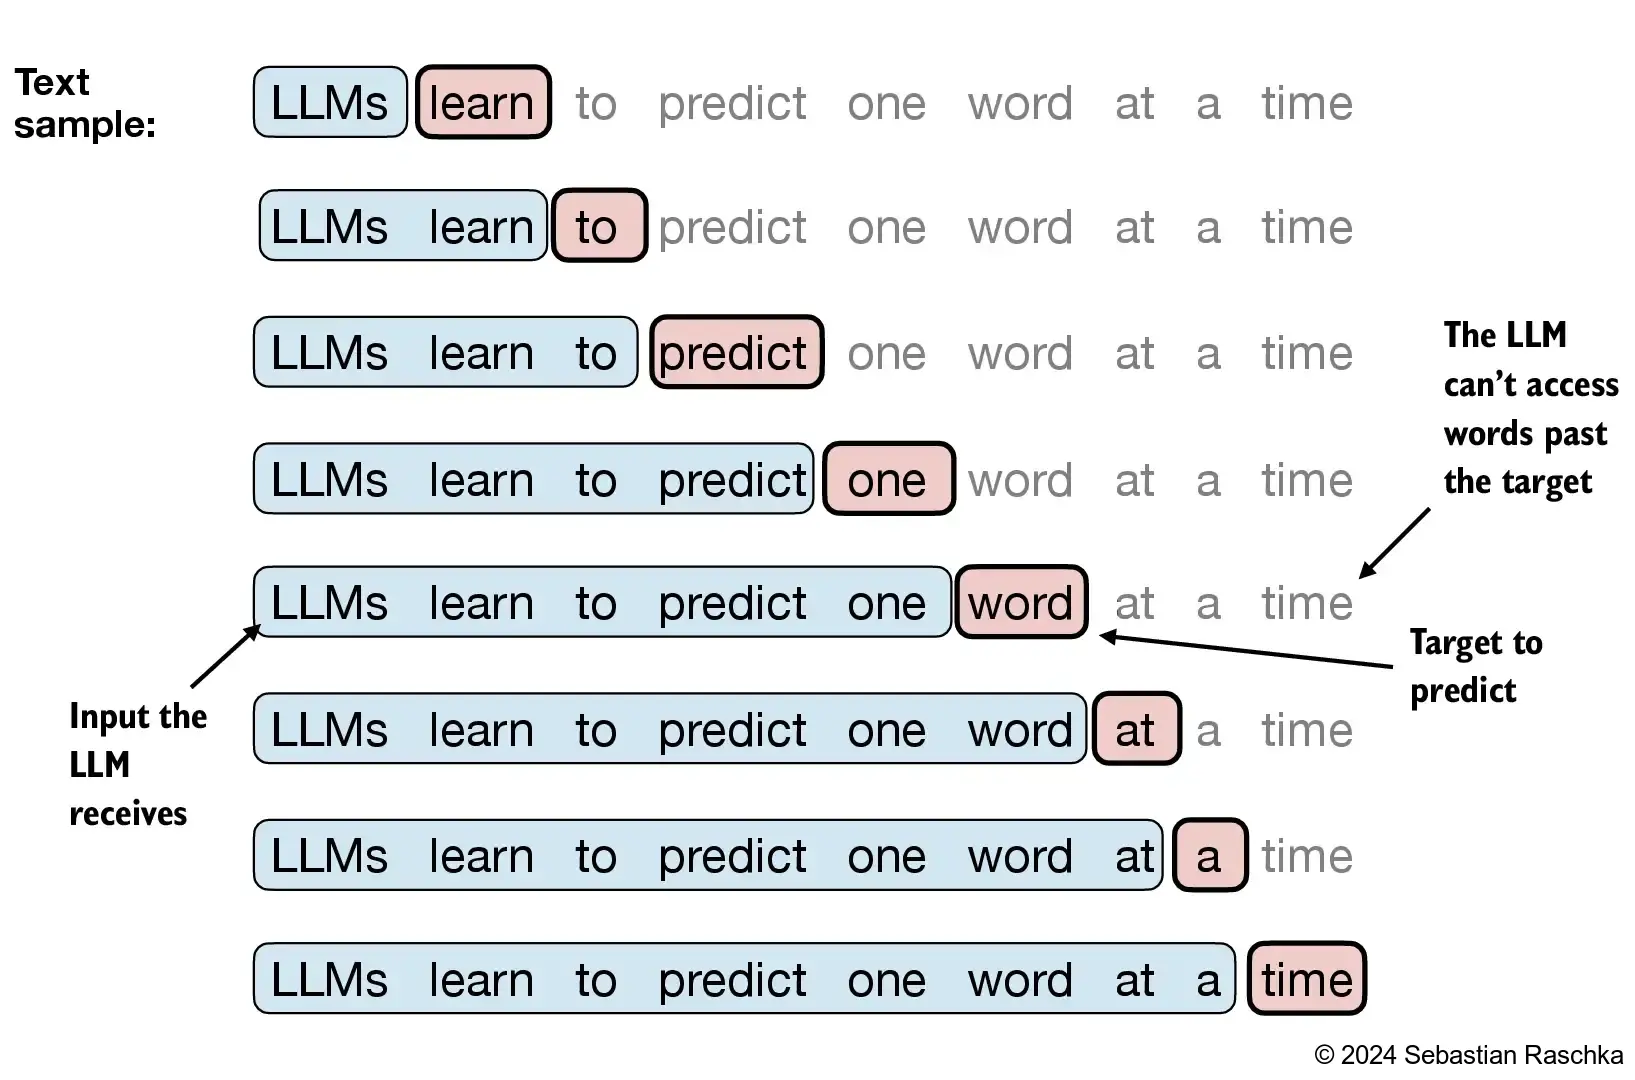

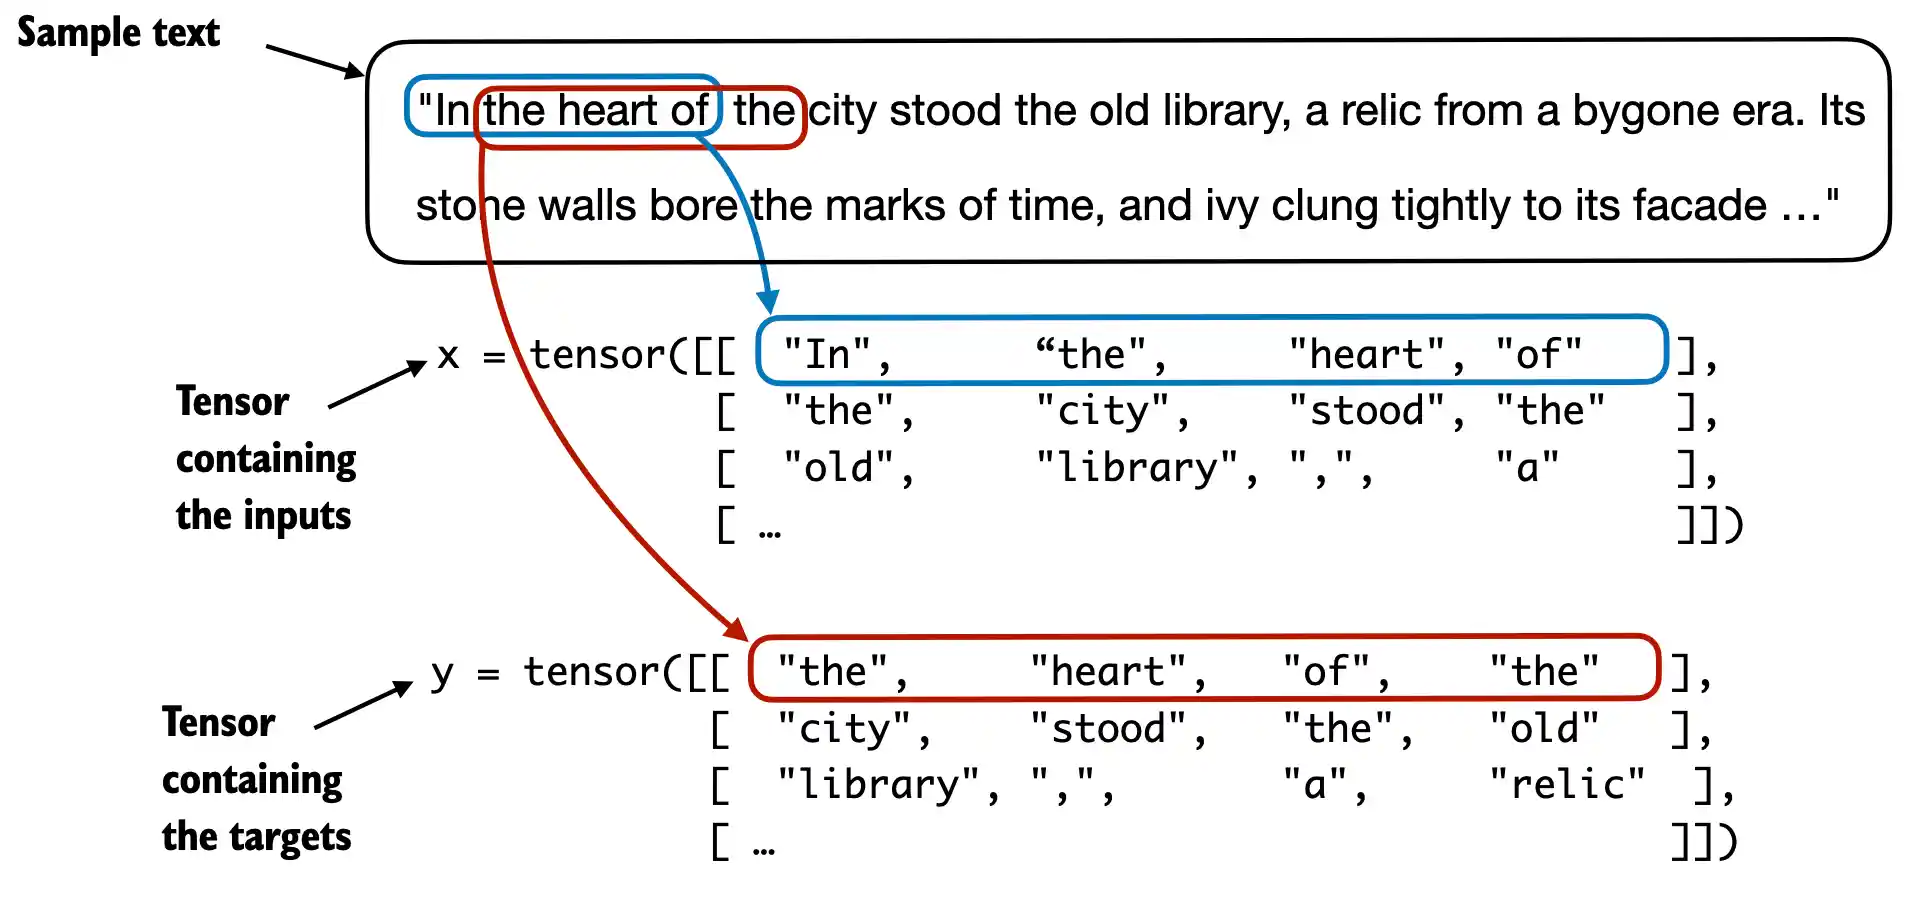

In [6]:
file_path = "verdict.txt"
raw_text = read_data(file_path)

bpe_tokenizer = tiktoken.get_encoding("gpt2")
tokens = bpe_tokenizer.encode(raw_text)

print(len(tokens))

5145


In [7]:
sample_text = tokens[50:]
context_size = 5

x = sample_text[:context_size]
y = sample_text[1:context_size+1]


for i in range(1, context_size+1):
  context = sample_text[:i]
  target = sample_text[i]
  print(f"when input is {context} the target: {target}")

  print(bpe_tokenizer.decode(context), "-->", bpe_tokenizer.decode([target]))


when input is [290] the target: 4920
 and -->  established
when input is [290, 4920] the target: 2241
 and established -->  himself
when input is [290, 4920, 2241] the target: 287
 and established himself -->  in
when input is [290, 4920, 2241, 287] the target: 257
 and established himself in -->  a
when input is [290, 4920, 2241, 287, 257] the target: 4489
 and established himself in a -->  vill


In [22]:
from torch.utils.data import Dataset, DataLoader
import torch

class GPTDatasetV1(Dataset):
  def __init__(self, text, tokenizer, context, stride, log=False):
    self.input_ids = []
    self.target_ids = []
    self.stride = stride
    self.log = log

    tokens = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

    if self.log:
      print("First 20 tokens are", tokens[0:20])
      print("First 20 decoded tokens are", tokenizer.decode(tokens[0:20]))

    for i in range(0, len(tokens) - context, stride):
      input_chunk = tokens[i : i + context]
      target_chunk = tokens[i + 1 : i + 1 + context]

      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

      if self.log and i <= 4:
        print(f"input ids", input_chunk)
        print(f"target ids", target_chunk)
        print(f"Input: {tokenizer.decode(input_chunk)}")
        print(f"Target: {tokenizer.decode(target_chunk)}")
        print(stride)
        print("\n\n")

    print(f"Number of training examples: {len(self.input_ids)}")

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(text, batch_size=4, context=256, stride=128, shuffle=True, drop_last=True, num_workers=0, log=False):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetV1(text, tokenizer, context, stride, log=log)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

  if log:
    print("First batch is", next(iter(dataloader)))

  return dataloader



In [23]:
dataloader = create_dataloader_v1(raw_text, batch_size=4, context=4, stride=1, shuffle=False, log=True)





First 20 tokens are [40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438]
First 20 decoded tokens are I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--
input ids [40, 367, 2885, 1464]
target ids [367, 2885, 1464, 1807]
Input: I HAD always
Target:  HAD always thought
1



input ids [367, 2885, 1464, 1807]
target ids [2885, 1464, 1807, 3619]
Input:  HAD always thought
Target: AD always thought Jack
1



input ids [2885, 1464, 1807, 3619]
target ids [1464, 1807, 3619, 402]
Input: AD always thought Jack
Target:  always thought Jack G
1



input ids [1464, 1807, 3619, 402]
target ids [1807, 3619, 402, 271]
Input:  always thought Jack G
Target:  thought Jack Gis
1



input ids [1807, 3619, 402, 271]
target ids [3619, 402, 271, 10899]
Input:  thought Jack Gis
Target:  Jack Gisburn
1



Number of training examples: 5141
First batch is [tensor([[  40,  367, 2885, 1464],
        [ 367, 2885, 1464, 180

- If stride is increased, the input is shifted faster. Increased stride would mean fewer training samples, but higher information per sample

In [24]:
dataloader_stride3 = create_dataloader_v1(raw_text, batch_size=4, context=4, stride=2, shuffle=False, log=True)





First 20 tokens are [40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438]
First 20 decoded tokens are I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--
input ids [40, 367, 2885, 1464]
target ids [367, 2885, 1464, 1807]
Input: I HAD always
Target:  HAD always thought
2



input ids [2885, 1464, 1807, 3619]
target ids [1464, 1807, 3619, 402]
Input: AD always thought Jack
Target:  always thought Jack G
2



input ids [1807, 3619, 402, 271]
target ids [3619, 402, 271, 10899]
Input:  thought Jack Gis
Target:  Jack Gisburn
2



Number of training examples: 2571
First batch is [tensor([[   40,   367,  2885,  1464],
        [ 2885,  1464,  1807,  3619],
        [ 1807,  3619,   402,   271],
        [  402,   271, 10899,  2138]]), tensor([[  367,  2885,  1464,  1807],
        [ 1464,  1807,  3619,   402],
        [ 3619,   402,   271, 10899],
        [  271, 10899,  2138,   257]])]


## Creating token embeddings

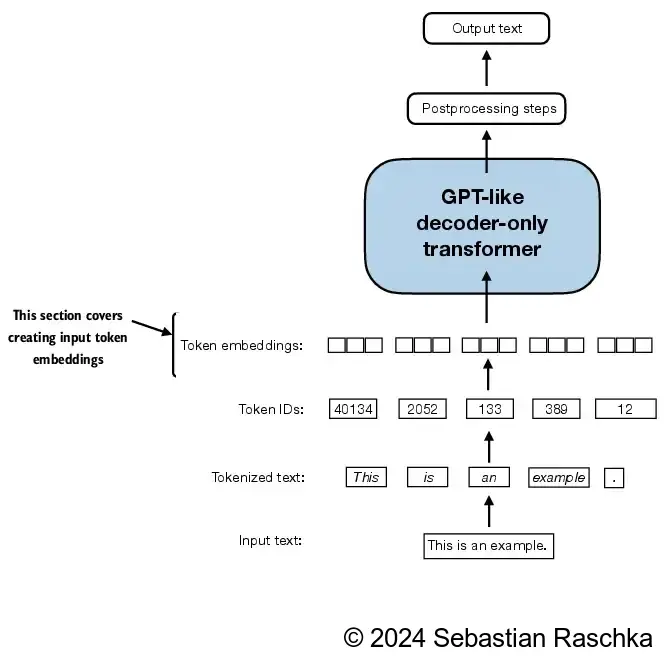

In [26]:
input_ids = torch.tensor([3, 2, 1])
vocab_size = 4
output_dim = 2

embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight.shape)
output = embedding_layer(input_ids)

print(output)

torch.Size([4, 2])
tensor([[-0.7999, -0.7163],
        [-0.2734, -1.4784],
        [ 2.5543,  0.3500]], grad_fn=<EmbeddingBackward0>)


- Embedding layer can be viewed as a look up operation.

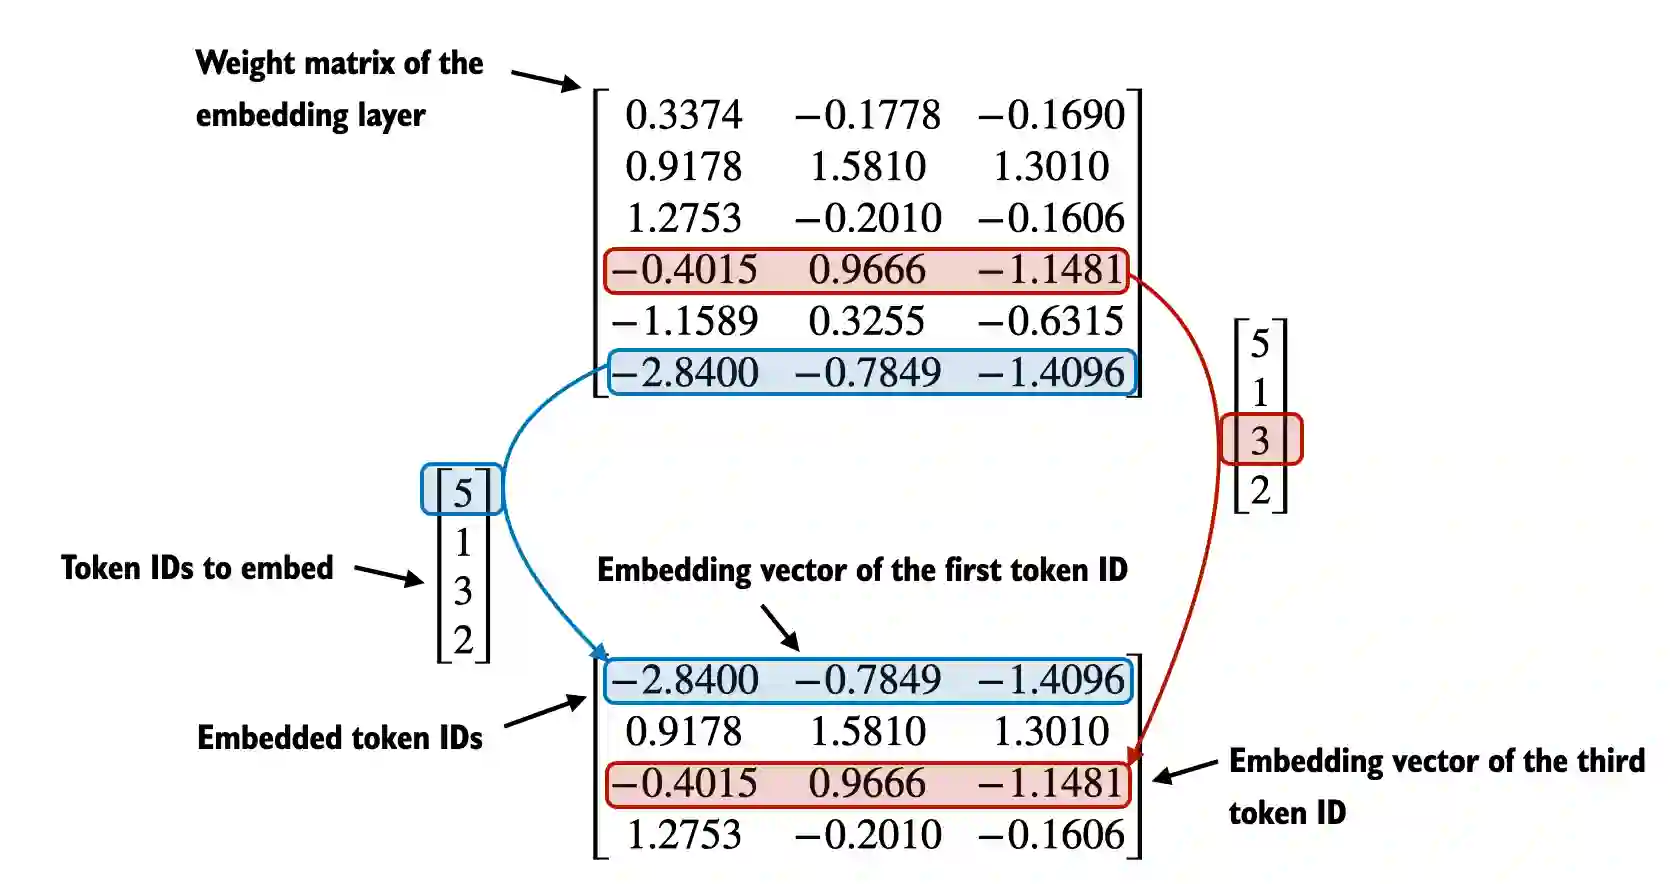

### Include positioning information1
- Include information about where input appears in the input. Create a positional embedding layer with same dimension as token embedding and add it to token embedding


In [33]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
context = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, context=context, stride=4, shuffle=False)

inputs, targets = next(iter(dataloader))



Number of training examples: 1286


In [31]:
token_embedding = token_embedding_layer(inputs)
print(token_embedding.shape)

torch.Size([8, 4, 256])


In [34]:
pos_embedding_layer = torch.nn.Embedding(context, output_dim)
pos_embedding = pos_embedding_layer(torch.arange(context))
print(pos_embedding.shape)

torch.Size([4, 256])


In [36]:
input_embedding = token_embedding + pos_embedding
print(input_embedding.shape)

torch.Size([8, 4, 256])


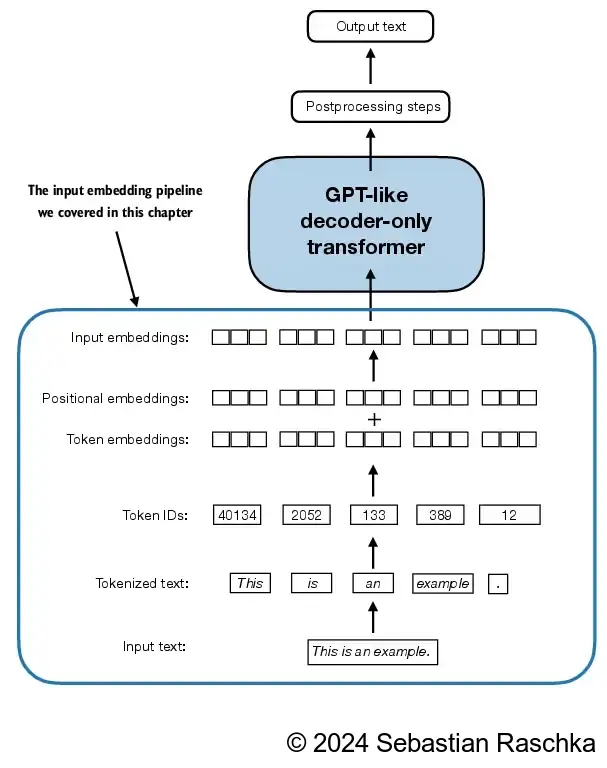